In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import time

# Rosenbrock banana 

Rosenbrock's "banana" function in $n$ dimensions is defined as

$$
	f_n(\mathbf{x}) = \sum_{i=1}^{n-1}\left[100(x_{i+1}-x_i^2)^2+(1-x_i)^2\right] ,
$$

where $\mathbf{x}\in\mathbb{R}^n$. 

This can be used to define a probability distribution over $\mathbb{R}^n$ with PDF $P_n(\mathbf{x})$ that is a good test case for sampling algorithms;

$$
    \log P_n(\mathbf{x}) = -f_n(\mathbf{x}) .
$$


In [2]:
def rosenbrock(x):
    """ 
    Rosenbrock's banana function
    
    Parameters
    ----------
    x: np.array
        input parameter vector
        shape=(num_dim,) 

    Returns
    ------- 
    ans: float
        banana function value
    """
    num_dim = len(x)
    mask = (np.arange(num_dim)<num_dim-1)
    ans = np.sum(100*(np.roll(x,-1)[mask]-x[mask]**2)**2+(1-x[mask])**2)
    return float(ans)

def log_prob(x):
    """ log PDF of target dist (up to normalisation constant) """
    return -rosenbrock(x)

We can plot this PDF in $n=2$ dimensions. The contours in the plot below contain 50% and 90% of the probability.

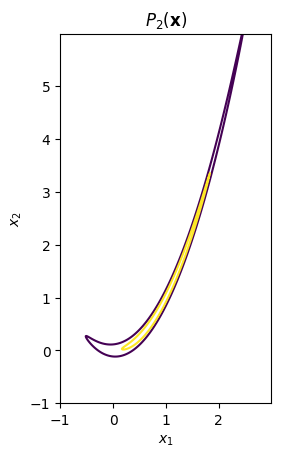

In [3]:
delta = 0.01
x = np.arange(-1.0, 3.0, delta)
y = np.arange(-1.0, 6.0, delta)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
for i in range(len(y)):
    for j in range(len(x)):
        Z[i,j] = np.exp(log_prob(np.array([x[j],y[i]])))

Z_vals_sorted = np.sort(Z.flatten())
pixel_prob_sorted = Z_vals_sorted * delta**2
integral = np.cumsum(pixel_prob_sorted)
integral /= integral[-1]
levels = [ Z_vals_sorted[np.argmin(np.abs(Z_vals_sorted-p))] for p in [0.1, 0.5] ]

fig, ax = plt.subplots()
ax.set_aspect('equal')

CS = ax.contour(X, Y, Z, levels)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title(r'$P_2(\mathbf{x})$')
plt.show()

Hereafter, we will be working with the function in $n=3$ dimensions.

In this notebook we will attempt to calculate the expectation of $|\mathbf{x}|$, for $\mathbf{x}\sim P$ with $n=3$.
This amounts to evaluating the following integral.

$$ 
    \mathrm{E}_{\mathbf{x}}\left[|\mathbf{x}|\right] 
    = \int\mathrm{d}\mathbf{x}\;|\mathbf{x}|P_n(\mathbf{x}) = \int_{-\infty}^{\infty}\mathrm{d}x_1\;\int_{-\infty}^{\infty}\mathrm{d}x_2\;\int_{-\infty}^{\infty}\mathrm{d}x_3\; \sqrt{x_1^2+x_2^2+x_3^2} P_3(x_1,x_2,x_3)
$$

We will do this using quadrature methods and stochastic samples obtained with a variety of Monte-Carlo algorithms:

- __Quadrature__ `scipy.integrate.tplquad`
- __Metropolis algorihtm__ a custom implementation
- __zeus__ (https://zeus-mcmc.readthedocs.io/en/latest/)
  can be installed with `!pip install zeus`
- __emcee__ (https://emcee.readthedocs.io/en/stable/)
  can be installed with `!pip install emcee`
- __dynesty__ (https://dynesty.readthedocs.io/en/stable/)
  can be installed with `!pip install dynesty`
- __nessai__ (https://nessai.readthedocs.io/en/latest/)
  can be installed with `!pip install nessai`

# (Attempting) Quadrature

This _really_ doesn't work!

In [4]:
#from scipy.integrate import tplquad
#
#limits = (-10, 10, -10, 10, -10, 10)
#
#func = lambda x, y, z: np.sqrt(x**2+y**2+z**2)*np.exp(log_prob(np.array([x,y,z])))
#
#tplquad(func, *limits)

# Metropolis

Written from scratch. Using a Gaussian proposal distribution, $y|x\sim\mathcal{N}(x, \delta I)$ where $\delta=0.1$ and $I$ is the 3-dimensional identity matrix.

In [5]:
from scipy.stats import multivariate_normal

nsteps, ndim = 100000, 3

delta = 0.008
cov = delta * np.eye(3)

chain = np.zeros((nsteps, 1, ndim))

chain[0,0] = np.ones(ndim)

num_accept = 0

t_start = time.time()

for i in range(nsteps-1):
    x_current = chain[i,0]                     # current position
    Q = multivariate_normal(x_current, cov)    # poposal distribution
    x_proposed = Q.rvs()                       # proposed position
    log_a = log_prob(x_proposed) - \
                log_prob(x_current)            # acceptance ratio
    u = np.random.uniform()                    # uniform random variable
    if np.log(u)<log_a:
        x_new = x_proposed                     # ACCEPT
        num_accept += 1                        # count how many proposals are accepted
    else:
        x_new = x_current                      # REJECT
    chain[i+1,0] = x_new                       # store new position in chain

print("Acceptance fraction = {}".format(num_accept/nsteps))

t_end = time.time()

Acceptance fraction = 0.25891


In [6]:
from zeus import AutoCorrTime

taus = AutoCorrTime(chain)
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")

ImportError: cannot import name 'Iterable' from 'collections' (/Users/vishaljain/anaconda3/envs/s2_cw/lib/python3.11/collections/__init__.py)

In [ ]:
fig, axs = plt.subplots(nrows=ndim, figsize=(5,ndim*2))
for i, ax in enumerate(axs):
    ax.plot(chain[:,0,i],alpha=0.25)
    if i==ndim-1:
        ax.set_xlabel('Iterations')
    else:
        ax.set_xticks([])
    ax.set_ylabel(r'$x_{'+str(i)+'}$')
    ax.set_xlim(0, nsteps)
plt.tight_layout()
plt.show()

In [ ]:
burnin = 0

iid_samples = chain[burnin::2*int(tau), 0, :]

num_samples = len(iid_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
# Here I am plotting the corner plot for the entire chain: no burnin and no thinning
corner(chain[:,0,:], labels=['x{}'.format(i) for i in range(ndim)])
plt.show()

In [ ]:
I = np.mean(np.linalg.norm(iid_samples, axis=1))
e = I*np.std(np.linalg.norm(iid_samples, axis=1))/np.sqrt(len(iid_samples))

print("integral = {0:1.4f} +/- {1:1.4f}".format(I, e))

# Zeus

Slice ensemble MCMC sampling

In [ ]:
import zeus

nsteps, nwalkers, ndim = 10000, 100, 3
start = np.random.randn(nwalkers, ndim)

sampler = zeus.EnsembleSampler(nwalkers, ndim, log_prob)

t_start = time.time()
sampler.run_mcmc(start, nsteps)
t_end = time.time()

In [ ]:
taus = zeus.AutoCorrTime(sampler.get_chain())
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")

In [ ]:
fig, axs = plt.subplots(nrows=ndim, figsize=(5,ndim*2))
for i, ax in enumerate(axs):
    ax.plot(sampler.get_chain()[:,:,i],alpha=0.25)
    if i==ndim-1:
        ax.set_xlabel('Iterations')
    else:
        ax.set_xticks([])
    ax.set_ylabel(r'$x_{'+str(i)+'}$')
    ax.set_xlim(0, nsteps)
plt.tight_layout()
plt.show()

In [ ]:
iid_samples = sampler.get_chain(flat=True, thin=2*int(tau), discard=0.05)

num_samples = len(iid_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
corner(iid_samples, labels=['x{}'.format(i) for i in range(ndim)])
plt.show()

In [ ]:
I = np.mean(np.linalg.norm(iid_samples, axis=1))
e = I*np.std(np.linalg.norm(iid_samples, axis=1))/np.sqrt(len(iid_samples))

print("integral = {0:1.4f} +/- {1:1.4f}".format(I, e))

# Emcee

Affine invariance ensemble MCMC sampling

In [ ]:
import emcee

nsteps, nwalkers, ndim = 10000, 100, 3
start = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

t_start = time.time()
sampler.run_mcmc(start, nsteps)
t_end = time.time()

In [ ]:
taus = sampler.get_autocorr_time(tol=2)
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")

In [ ]:
fig, axs = plt.subplots(nrows=ndim, figsize=(5,ndim*2))
for i, ax in enumerate(axs):
    ax.plot(sampler.get_chain()[:,:,i],alpha=0.25)
    if i==ndim-1:
        ax.set_xlabel('Iterations')
    else:
        ax.set_xticks([])
    ax.set_ylabel(r'$x_{'+str(i)+'}$')
    ax.set_xlim(0, nsteps)
plt.tight_layout()
plt.show()

In [ ]:
iid_samples = sampler.get_chain(flat=True, thin=2*int(tau), discard=int(0.05*nsteps))

num_samples = len(iid_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
corner(iid_samples, labels=['x{}'.format(i) for i in range(ndim)])
plt.show()

In [ ]:
I = np.mean(np.linalg.norm(iid_samples, axis=1))
e = I*np.std(np.linalg.norm(iid_samples, axis=1))/np.sqrt(len(iid_samples))

print("integral = {0:1.4f} +/- {1:1.4f}".format(I, e))

# Dynesty

Nested sampling

In [ ]:
import dynesty

ndim = 3

def prior_transform(u):
    return 20*u-10.

sampler = dynesty.NestedSampler(log_prob, prior_transform, ndim, bound='multi', sample='slice', nlive=1000)

t_start = time.time()
sampler.run_nested(dlogz=0.01)
t_end = time.time()

res = sampler.results

In [ ]:
corner(res['samples'], weights=np.exp(res['logwt']))
plt.show()

In [ ]:
num_samples = sampler.n_effective

print("Effective number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
I = np.sum(np.linalg.norm(res['samples'], axis=1)*np.exp(res['logwt']))/np.sum(np.exp(res['logwt']))
e = I*np.std(np.linalg.norm(iid_samples, axis=1))/np.sqrt(num_samples)

def average_and_stddev(x, w):
    av = np.average(x, weights=w)
    var = np.average((x-av)**2, weights=w)
    return av, np.sqrt(var)

I, e = average_and_stddev(np.linalg.norm(res['samples'], axis=1), np.exp(res['logwt']))

print("integral = {0:1.4f} +/- {1:1.4f}".format(I, e))

# Nessai

Nested Sampling with Artificial Intelligence

In [ ]:
import nessai
from nessai.model import Model
from nessai.flowsampler import FlowSampler

class my_model(Model):
    def __init__(self, dim=3):
        self.dim = dim
        self.names = ['x{}'.format(i) for i in range(self.dim)]
        self.bounds ={'x{}'.format(i): [-10, 10] for i in range(self.dim)}

    def log_prior(self, x):
        return np.log(1., dtype="float")
    
    def log_likelihood(self, x):
        return -rosenbrock(np.array([x['x{}'.format(i)] for i in range(self.dim)]))

sampler = FlowSampler(my_model(), output='nessai_output', nlive=10000)

t_start = time.time()
sampler.run()
t_end = time.time()

In [ ]:
nessai_samples = np.vstack((
                        sampler.posterior_samples['x0'], 
                        sampler.posterior_samples['x1'], 
                        sampler.posterior_samples['x2']
                    )).T

num_samples = len(nessai_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
corner(nessai_samples)
plt.show()

In [ ]:
I = np.mean(np.linalg.norm(nessai_samples, axis=1))
e = I*np.std(np.linalg.norm(nessai_samples, axis=1))/np.sqrt(len(nessai_samples))

print("integral = {0:1.4f} +/- {1:1.4f}".format(I, e))

# Tensorflow HMC

Hamiltonian MCMC

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

# a new version of the target PDF function compatible with tensorflow
def target_log_prob_fn(x):
    num_dim = 3
    A = 100*(tf.roll(x,-1,1)-x**2)**2+(1-x)**2
    ans = tf.reduce_sum(A[:,0:-1],axis=-1)
    return -ans

In [ ]:
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=target_log_prob_fn,
  step_size=np.float64(.01),
  num_leapfrog_steps=200)

@tf.function
def run_chain(initial_state, num_results=30000, num_burnin_steps=10):
  return tfp.mcmc.sample_chain(
                            num_results=num_results,
                            num_burnin_steps=num_burnin_steps,
                            current_state=initial_state,
                            kernel=hmc_kernel,
                            trace_fn=lambda current_state, kernel_results: kernel_results)

num_chains, ndim = 8, 3
initial_state = np.random.normal(size=(num_chains, ndim))

t_start = time.time()
chains, kernel_results = run_chain(initial_state)
t_end = time.time()

In [ ]:
r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per latent variable):", r_hat.numpy())

In [ ]:
from zeus import AutoCorrTime

taus = AutoCorrTime(np.array(chains))
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")

In [ ]:
fig, axs = plt.subplots(nrows=ndim, figsize=(5,ndim*2))
for i, ax in enumerate(axs):
    ax.plot(np.array(chains)[:,0,i], alpha=0.25)
    if i==ndim-1:
        ax.set_xlabel('Iterations')
    else:
        ax.set_xticks([])
    ax.set_ylabel(r'$x_{'+str(i)+'}$')
    ax.set_xlim(0, np.array(chains).shape[0])
plt.tight_layout()
plt.show()

In [ ]:
thinned_chains = chains.numpy()[::2*int(tau)]

a,b,c = thinned_chains.shape
iid_tf_samples = thinned_chains.reshape(a*b, c)

num_samples = len(iid_tf_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
corner(iid_tf_samples)
plt.show()

In [ ]:
I = np.mean(np.linalg.norm(iid_tf_samples, axis=1))
e = I*np.std(np.linalg.norm(iid_tf_samples, axis=1))/np.sqrt(len(iid_tf_samples))

print("integral = {0:1.4f} +/- {1:1.4f}".format(I, e))

# Comparing Sampling Methods

Running on a my laptop, we can compare the above sampling methods based on the time taken to produce independent samples from the target distribution.

| Method | Time [ms] per i.i.d. sample |
| ------ | --------------------------- |
| Simple custom Metropolis implementation | 1200 |
| Zeus | 78 |
| Emcee | 9 |
| Dynesty | 3 |
| Nessai | 0.4 |
| Tensorflow HMC | 9 |

You should definitely NOT treat this a definitive comparison of the algorithms in general. These times depend sensitively on the specific target distribution, the dimensionality and the specific implementation. Most algorithms have parameters that can be tuned which can drastically alter the sampling efficiency (this is both a blessing and a curese). For most algorithms, the cost also doesn't scale linearly with the number of samples produced (e.g. for adaptive algorithms it might be cheaper to produce the second 100 samples than it was to produce the first 100). Differant algorithms can be easier or harder to implement (some require derivatives). When working on larger scale problems using HPC resources different algorithms/implementations can be easier or harder to parallelise. 

Q: Which sampler should I use? 

A: It depends.

# The case of $n=4$

Any of the above stochastic sampling method can easily be adapted to work in any number of dimensions.

Here I show a simple custom Metropolis method in 4D.

In [ ]:
from scipy.stats import multivariate_normal

nsteps, ndim = 1000000, 4

delta = 0.003
cov = delta * np.eye(ndim)

chain = np.zeros((nsteps, 1, ndim))

chain[0,0] = np.ones(ndim)

num_accept = 0

t_start = time.time()

for i in range(nsteps-1):
    x_current = chain[i,0]                     # current position
    Q = multivariate_normal(x_current, cov)    # poposal distribution
    x_proposed = Q.rvs()                       # proposed position
    log_a = log_prob(x_proposed) - \
                log_prob(x_current)            # acceptance ratio
    u = np.random.uniform()                    # uniform random variable
    if np.log(u)<log_a:
        x_new = x_proposed                     # ACCEPT
        num_accept += 1                        # count how many proposals are accepted
    else:
        x_new = x_current                      # REJECT
    chain[i+1,0] = x_new                       # store new position in chain

print("Acceptance fraction = {}".format(num_accept/nsteps))

t_end = time.time()

In [ ]:
from zeus import AutoCorrTime

taus = AutoCorrTime(chain)
print('Autocorrelation:', taus)

tau = max(taus)
print(f"{tau = }")

In [ ]:
burnin = 0

iid_samples = chain[burnin::2*int(tau), 0, :]

num_samples = len(iid_samples)

print("Number of i.i.d. samples produced = {}".format(num_samples))
print("Time taken per i.i.d. sample = {}s".format((t_end-t_start)/num_samples))

In [ ]:
corner(chain[:,0,:], labels=['x{}'.format(i) for i in range(ndim)])
plt.show()